In [21]:
import os.path

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchaudio

from torchaudio import transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import librosa


In [22]:
df = pd.read_csv('../data/maestro-v2.0.0/maestro-v2.0.0.csv')

In [23]:
df.head()

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration
0,Alban Berg,Sonata Op. 1,train,2018,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,698.661160
1,Alban Berg,Sonata Op. 1,train,2008,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,759.518471
2,Alban Berg,Sonata Op. 1,train,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433
3,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",train,2004,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,872.640588
4,Alexander Scriabin,"3 Etudes, Op. 65",validation,2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508


In [24]:
df['duration'].mean()

565.0345682827794

In [25]:
torchaudio.load('../data/maestro-v2.0.0/2014/MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_12_R2_2014_wav.mp3')[0].s

AttributeError: 'Tensor' object has no attribute 's'

In [57]:
import random
class AudioDataset(Dataset):
    def __init__(self, path: str, sample_length=9.99, sample_rate=8000):
        super().__init__()
        self.path = path
        self.df = pd.read_csv(os.path.join(path, 'maestro-v2.0.0.csv'))
        self.sample_rate = sample_rate
        self.sample_length_frames = int(sample_length * sample_rate)  # Length of the audio segment to sample in frames

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index: int):
        filename = self.df.iloc[index]['audio_filename']
        filename = filename[:-3] + "mp3"
        path = os.path.join(self.path, filename)

        # Load the entire audio file
        audio, original_sample_rate = torchaudio.load(path, normalize=True)

        # Resample audio if necessary
        if original_sample_rate != self.sample_rate:
            transform = torchaudio.transforms.Resample(original_sample_rate, self.sample_rate)
            audio = transform(audio)

        # Ensure audio length is at least as long as the desired segment length
        if audio.size(1) < self.sample_length_frames:
            padding = torch.zeros(audio.size(0), self.sample_length_frames - audio.size(1))
            audio = torch.cat([audio, padding], dim=1)

        # Randomly sample a segment from the audio
        if audio.size(1) > self.sample_length_frames:
            start_frame = random.randint(0, audio.size(1) - self.sample_length_frames)
            audio = audio[:, start_frame:start_frame + self.sample_length_frames]

        return audio

ds = AudioDataset('../data/maestro-v2.0.0')

In [ ]:
# class AudioDataset(Dataset):
#     def __init__(self, path: str, sample_rate=16000):
#         super().__init__()
#         self.path = path
#         self.df = pd.read_csv(os.path.join(path, 'features_30_sec.csv'))
#         self.min_audio_len = self.df['length'].min()
#         self.sample_rate = sample_rate
#         self.df = self.df[self.df['filename'] != 'jazz.00054.wav']
#     def __len__(self):
#         return len(self.df)
#     
#     def __getitem__(self, index: int):
#         genre = self.df.iloc[index]['label']
#         filename = self.df.iloc[index]['filename']
#         path = os.path.join(self.path, 'genres_original', genre, filename)
#         audio, sample_rate = torchaudio.load(path, normalize=True, num_frames=self.min_audio_len)
#         transform = torchaudio.transforms.Resample(sample_rate, self.sample_rate)
#         audio = transform(audio)
#         return audio

In [ ]:
ds[1].size()

In [59]:
# ds = AudioDataset('../data')
# from torch.nn.utils.rnn import pad_sequence
# def collate_fn(batch):
#     # batch is a list of tuples, each containing a waveform and its corresponding label or metadata
#     waveforms_batch = [item[0] for item in batch]
#     # Pad the waveforms to the same length
#     padded_waveforms = pad_sequence(waveforms_batch, batch_first=True)
#     if padded_waveforms.size()[1] <= 80000:
#         padding = torch.zeros(padded_waveforms.size(0), 80000 - padded_waveforms.size(1))
#         padded_waveforms = torch.cat([padded_waveforms, padding], dim=1)
#     return padded_waveforms
dl = DataLoader(dataset=ds, batch_size=4, shuffle=True)

In [27]:
transform = transforms.MelSpectrogram(sample_rate=ds.sample_rate)

In [28]:
class VAE(nn.Module):
    class Encoder(nn.Module):
        def __init__(self, latent_dim=100):
            super().__init__()
        def forward(self, x: torch.Tensor) -> torch.Tensor:
            pass
        
    def __init__(self, latent_dim=100):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 20, 3),
            nn.ReLU(),
            nn.Conv2d(20, 10, 3),
            nn.ReLU(),
            nn.Conv2d(10, 10, 3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(10 * 122 * 2389, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 10 * 122 * 2389),
            nn.ReLU(),
            # nn.
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        pass

NameError: name 'override' is not defined

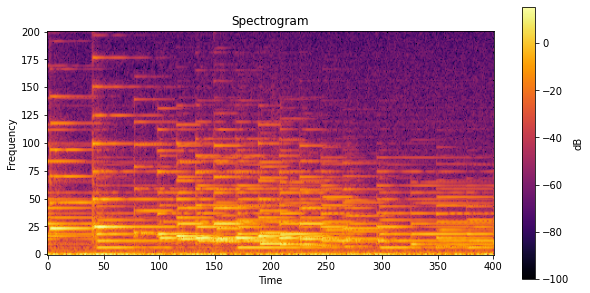

In [29]:
spectrogram = torchaudio.transforms.Spectrogram()(ds[100][0])

# Convert spectrogram to decibels
log_spectrogram = torchaudio.transforms.AmplitudeToDB()(spectrogram)

# Display spectrogram
plt.figure(figsize=(10, 5))
plt.imshow(log_spectrogram.numpy(), cmap='inferno', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogram')
plt.colorbar(label='dB')
plt.show()

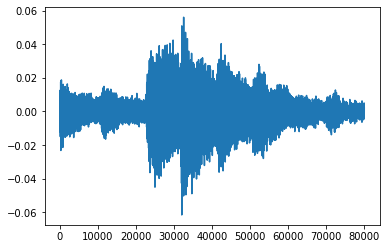

In [30]:
plt.plot(ds[0][1])

In [ ]:
plt.plot(ds[0][0])

In [50]:
encoder = nn.Sequential(
    nn.Conv2d(2, 10, 5),
    nn.ReLU(),
    nn.Conv2d(10, 10, 3),
    nn.ReLU(),
    nn.Conv2d(10, 10, 3),
    nn.ReLU(),
    nn.Flatten(),
    # nn.Linear(1414800, 10000),
    # nn.ReLU(),
    # nn.Linear(10000, 
)

In [51]:
transform(ds[0]).size()

torch.Size([2, 128, 401])

In [52]:
encoder(transform(ds[0]).unsqueeze(0)).size()

torch.Size([1, 471600])

In [ ]:
df.iloc[256]

In [60]:
for i, item in enumerate(dl):
    # item = item.squeeze(1)
    item = transform(item)
    print(item.size())

torch.Size([4, 2, 128, 400])


KeyboardInterrupt: 